# Analysing time series economical data using RNN


# Data preprocessing

In [65]:
# import libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [66]:
# read data (industrial data that measures elevant establishments located in the United States)
data = pd.read_csv('production.csv', index_col='DATE',parse_dates=True)

In [67]:
data.columns = ['Production']
data.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


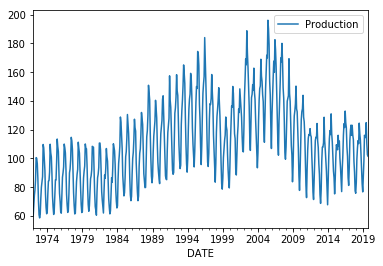

In [68]:
data.plot()

In [69]:
## train_test_split 
# note that we don't split randomly 
len(data)

573

In [70]:
length_data = 24
train_data = data[: len(data)-length_data]
test_data = data[-length_data:]

In [71]:
train_data

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
1972-06-01,100.5960
1972-07-01,100.1263
1972-08-01,96.3607
1972-09-01,85.8007


In [72]:
len(test_data)

24

In [73]:
test_data

,Production
DATE,
2017-10-01,90.4732
2017-11-01,77.4378
2017-12-01,75.8118
2018-01-01,83.4343
2018-02-01,99.4899
2018-03-01,107.3152
2018-04-01,112.4309
2018-05-01,110.3544
2018-06-01,124.5841


In [74]:
# scale data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data)
train_scaled_data = scaler.transform(train_data)
test_scaled_data = scaler.transform(test_data)

In [75]:
# create the time series generator 
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [76]:
batch_size = 1
generator = TimeseriesGenerator(train_scaled_data, train_scaled_data, length=length, batch_size=batch_size)

In [77]:
x,y = generator[0]
x

array([[[0.00947104],
        [0.06108982],
        [0.11326273],
        [0.14145625],
        [0.18982663],
        [0.30495972],
        [0.30154406],
        [0.27416065],
        [0.19736841],
        [0.08532665],
        [0.01561588],
        [0.        ],
        [0.01774221],
        [0.09850931],
        [0.15590133],
        [0.18358944],
        [0.20878908],
        [0.37150354],
        [0.3542551 ],
        [0.29817568],
        [0.23973867],
        [0.12104304],
        [0.05289938]]])

In [48]:
y

array([[0.03141355]])

# Create the Model

In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense 

In [79]:
num_features = 1 
length= 23
model = Sequential()
model.add(LSTM(200, input_shape = (length, num_features))) # 200 neurons
model.add(Dense(1)) # we need to predict only the next value 

model.compile(optimizer='adam', loss='mse') # mse for continuous data 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [80]:
# create an earlystop and validation generator to start training
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3)
val_generator = TimeseriesGenerator(test_scaled_data, test_scaled_data, length=length, batch_size=batch_size)

In [81]:
model.fit_generator(generator, epochs=10, validation_data = val_generator, callbacks=[early_stop])

Epoch 1/10
526/526 [==============================] - 142s 270ms/step - loss: 0.0180 - val_loss: 0.0020
Epoch 2/10
526/526 [==============================] - 77s 147ms/step - loss: 0.0047 - val_loss: 0.0014
Epoch 3/10
526/526 [==============================] - 71s 136ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 4/10
526/526 [==============================] - 70s 133ms/step - loss: 0.0035 - val_loss: 9.9382e-04
Epoch 5/10
526/526 [==============================] - 66s 125ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 6/10
526/526 [==============================] - 63s 120ms/step - loss: 0.0034 - val_loss: 0.0099
Epoch 7/10
526/526 [==============================] - 63s 120ms/step - loss: 0.0033 - val_loss: 0.0033


In [83]:
loss = pd.DataFrame(model.history.history)

In [85]:
loss.head()

,loss,val_loss
0,0.017966,0.001964
1,0.004694,0.001382
2,0.003822,0.002438
3,0.003518,0.000994
4,0.003298,0.001099


(0.0, 0.09)

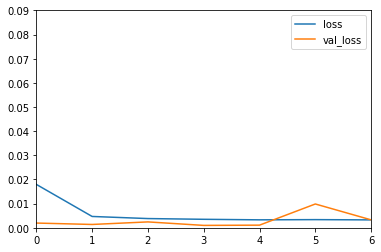

In [96]:
loss.plot()
plt.ylim(0.000,0.09)

# Model evaluation

In [100]:
# Forecast using the last 18 months from the dataset
length_forecast = 23 
forecast = []

scaled_data= scaler.fit_transform(data)
first_eval_batch = scaled_data[-length_forecast:]
current_batch = first_eval_batch.reshape((1, length_forecast, num_features))

for i in range(len(test_data)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [106]:
forecast_inverse_scaled = scaler.inverse_transform(forecast)
test_data['predictions'] = forecast_inverse_scaled

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [107]:
test_data

,Production,predictions
DATE,,
2017-10-01,90.4732,91.784886
2017-11-01,77.4378,89.309350
2017-12-01,75.8118,92.314103
2018-01-01,83.4343,99.218866
2018-02-01,99.4899,107.222606
2018-03-01,107.3152,114.061672
2018-04-01,112.4309,118.448659
2018-05-01,110.3544,119.784774
2018-06-01,124.5841,117.721108


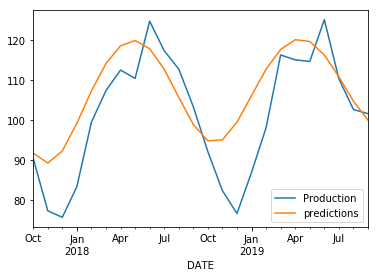

In [108]:
test_data.plot()